
The direct colab link to this notebook is [here](https://colab.research.google.com/github/D3Mlab/ppandas/blob/master/experiments/Chicago_West_Nile_CoLab.ipynb).

# Package Imports

In [0]:
!pip install -i https://test.pypi.org/simple/ PPandas==0.0.1.6.9
!pip install pgmpy==0.1.9
!pip install networkx==2.4
!pip install matplotlib
!pip install python-intervals
!pip install geopandas
!pip install geovoronoi
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
from rtree import index
from rtree.index import Rtree

Looking in indexes: https://test.pypi.org/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [0]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.ops import unary_union
from shapely.geometry import Point
from geovoronoi import voronoi_regions_from_coords
from geovoronoi import points_to_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from ppandas import PDataFrame
from ppandas.helper.spatial_helper import SpatialHelper

# Data Preprocessing

### Chicago Community Areas

Create a DataFrame using the Chicago Community Area shapefile CSV found [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

In [0]:
# Shapefile
comm_shp_df = pd.read_csv("CommAreas.csv")[['the_geom','COMMUNITY']]
comm_shp_df['COMMUNITY'].replace({'LOOP':'THE LOOP','OHARE':"O'HARE"},inplace=True)
comm_shp_df.head()

,the_geom,COMMUNITY
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,DOUGLAS
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,OAKLAND
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,FULLER PARK
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,GRAND BOULEVARD
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,KENWOOD


Create a DataFrame using the 2008-2012 Chicago Community Area Snapshot dataset found [here](https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2). This DataFrame contains the median income quintile that each Community Area belongs to.

In [0]:
# Median income
comm_stats_df = pd.read_csv('Reference_CCAProfiles_2008_2012.csv')[['CCA','MEDINC']] 
comm_stats_df['CCA'] = comm_stats_df['CCA'].str.upper() 
comm_join_df = pd.merge(comm_shp_df,comm_stats_df,how='outer',left_on='COMMUNITY',right_on='CCA')
comm_join_df.rename({'CCA':'COMMUNITY','the_geom':'geometry'},axis=1, inplace=True)
#Bin median income column
comm_join_df['MEDINCquintile'] = pd.qcut(comm_join_df['MEDINC'],q=5,labels=['0 to 0.2','0.2 to 0.4','0.4 to 0.6','0.6 to 0.8','0.8 to 1'])
comm_regions_obj = SpatialHelper.getGeoObjectsFromString(comm_join_df.geometry.values)

Create shapely polygons from strings and plot median income map

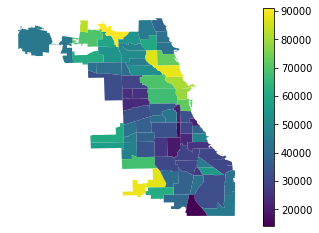

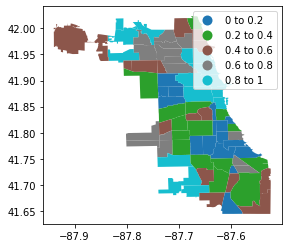

In [0]:
comm_join_df['geometry'] = comm_join_df['geometry'].apply(wkt.loads)
comm_join_gdf = gpd.GeoDataFrame(comm_join_df,geometry='geometry')
comm_join_gdf.plot(column='MEDINC', legend=True)
plt.axis('off')
plt.show()
comm_join_gdf.plot(column='MEDINCquintile', legend=True)
plt.show()

In [0]:
comm_join_df['Region'] = SpatialHelper.convertGeoObjectsToString(list(comm_regions_obj))
comm_join_df.drop(['COMMUNITY','MEDINC','geometry'],axis=1,inplace=True)

### Chicago West Nile Surveillance

Create DataFrame using the West Nile Surveillance dataset found [here](https://www.kaggle.com/c/predict-west-nile-virus/data). The longitude and latitude of each mosquito trap are combined into a single column.

In [0]:
train_df = pd.read_csv("train.csv")[['Date', 'Species','Longitude', 'Latitude','NumMosquitos', 'WnvPresent']]
train_df['Region'] = list(zip(train_df.Longitude, train_df.Latitude)) 
train_df.drop(columns=["Longitude","Latitude"],inplace=True)
train_df.head()

,Date,Species,NumMosquitos,WnvPresent,Region
0,2007-05-29,CULEX PIPIENS/RESTUANS,1,0,"(-87.800991, 41.95469)"
1,2007-05-29,CULEX RESTUANS,1,0,"(-87.800991, 41.95469)"
2,2007-05-29,CULEX RESTUANS,1,0,"(-87.769279, 41.994991)"
3,2007-05-29,CULEX PIPIENS/RESTUANS,1,0,"(-87.824812, 41.974089)"
4,2007-05-29,CULEX RESTUANS,4,0,"(-87.824812, 41.974089)"


Remove traps from dataset that fall outside Chicago

In [0]:
points = SpatialHelper.getGeoObjectsFromString(list(set(train_df.Region)))
area_shape = unary_union(comm_regions_obj)
for point in points:
    if not point.within(area_shape):
        points.remove(point)
        train_df = train_df[train_df.Region != (point.x,point.y)]

Create and plot a Voronoi Diagram using the trap locations

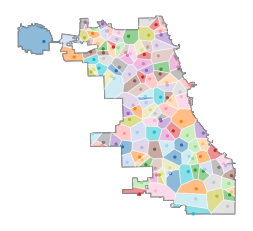

In [0]:

coords = points_to_coords(points)
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape)
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, coords, poly_to_pt_assignments,voronoi_edgecolor='white')
plt.axis('off')
plt.show()

Map mosquito traps to Voronoi cells and map the number of mosquitoes in each trap to a mosquito amount quintile to reduce that attribute's cardinality

In [0]:
pointRegionDict = {}
for point in list(set(train_df.Region)):
    point_shp = Point(point)
    for poly in poly_shapes:
        if point_shp.within(poly):
            pointRegionDict[point] = poly
            break
train_df.Region=train_df.Region.map(pointRegionDict)
train_df.Region = train_df.Region.astype(str)
train_df['Month'] = pd.DatetimeIndex(train_df['Date']).month
train_df['numMosQuintile'] = pd.qcut(train_df['NumMosquitos'],q=4,labels=['0 to 12','13 to 25','26 to 38','39 to 50'])
train_df.drop(['Species','Date','NumMosquitos'],axis=1,inplace=True)

# ppandas Analysis

Create two PDataFrames, one for the West Nile Surveillance and another for the Community Area Median Income

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


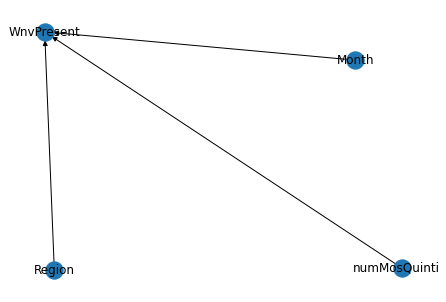

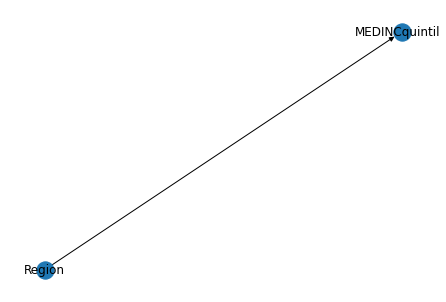

In [0]:
df1 = train_df
df2 = comm_join_df
pd1 = PDataFrame(independent_vars=['numMosQuintile','Month','Region'],data=df1)
pd1.visualise()
pd2 = PDataFrame(independent_vars=["Region"],data=df2)
pd2.visualise()

Perform a pjoin of the two PDataFrames where "pd1" is the reference model and the type of mismatch that occurs is spatial mismatch involving the Region attribute since the Voronoi Diagram cells differ from the Community Area boundaries. The following plot shows the spatial cross product of the two spatial representations.

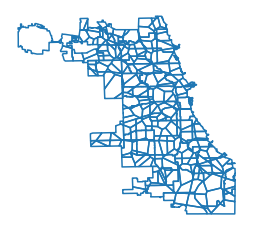

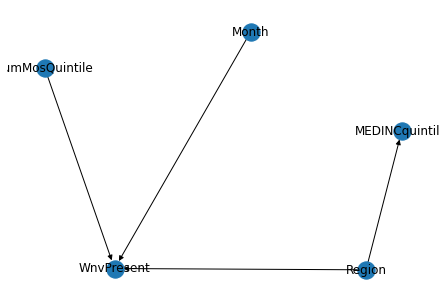

In [0]:
pd_join = pd1.pjoin(pd2, mismatches={"Region":"spatial"})
pd_join.visualise()

Perform Variable Elimination to query the probability of West Nile Virus given median income

In [0]:
queryResult = pd_join.query(['WnvPresent'],{"MEDINCquintile":'0 to 0.2'})
print(queryResult)
queryResult = pd_join.query(['WnvPresent'],{"MEDINCquintile":'0.2 to 0.4'})
print(queryResult)
queryResult = pd_join.query(['WnvPresent'],{"MEDINCquintile":'0.4 to 0.6'})
print(queryResult)
queryResult = pd_join.query(['WnvPresent'],{"MEDINCquintile":'0.6 to 0.8'})
print(queryResult)
queryResult = pd_join.query(['WnvPresent'],{"MEDINCquintile":'0.8 to 1'})
print(queryResult)

   WnvPresent  Probability(WnvPresent)
0         0.0                 0.708799
1         1.0                 0.291201
   WnvPresent  Probability(WnvPresent)
0         0.0                 0.833971
1         1.0                 0.166029
   WnvPresent  Probability(WnvPresent)
0         0.0                 0.832853
1         1.0                 0.167147
   WnvPresent  Probability(WnvPresent)
0         0.0                 0.790751
1         1.0                 0.209249
   WnvPresent  Probability(WnvPresent)
0         0.0                 0.757162
1         1.0                 0.242838
